# Training a Model

Now that I've got data in Hopsworks and the architecture for updating it, I can go ahead and start the process of constructing training data and then training a model.

In [1]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/14486
Connected. Call `.close()` to terminate connection gracefully.


In [2]:
# Load feature group.
zip_code = '60603'  # Chicago
country_code = 'US'
city = 'Chicago'

fg_name = f'aqi_{city}_{zip_code}'.lower()

aqi_online_fg = fs.get_feature_group(fg_name, version=1)

not_features = ['date', 'lat', 'lon']

ds_query = aqi_online_fg.select_except(not_features)

In [3]:
ds_query.show(5, online=True)

,co,no,no2,o3,so2,pm2_5,pm10,nh3,datetime,aqi,id
0,230.31,0.00,8.23,70.81,3.37,0.78,1.96,0.47,2020-11-30 08:00:00,1,80
1,1041.41,85.83,71.29,0.00,10.01,47.22,71.06,2.72,2020-12-08 02:00:00,4,266
2,297.07,0.05,22.96,41.84,4.17,5.59,7.95,2.38,2020-12-13 23:00:00,1,407
3,333.79,7.15,20.22,26.11,8.46,8.83,11.68,1.33,2020-12-21 12:00:00,1,588
4,330.45,0.06,30.16,38.62,5.66,14.31,17.61,1.36,2020-12-27 20:00:00,2,740


Notice that the data appears to be out of order. This is ok.

I will now define some transformation functions to standardize all of our features. These transformations will be applied to the data when I create a feature view.

In [4]:
# Load the transformation function we want.
standard_scaler = fs.get_transformation_function(name="standard_scaler")

# Map features to transformation function
transformation_functions = {
    'co': standard_scaler, 
    'no': standard_scaler, 
    'no2': standard_scaler, 
    'o3': standard_scaler,
    'so2': standard_scaler, 
    'pm2_5': standard_scaler, 
    'pm10': standard_scaler, 
    'nh3': standard_scaler
}

Training data is created from feature views in Hopsworks. Feature views are logical views over sets of features. Normally they are created by joining together different feature groups. Since I only have one here though it's a little different.

In [5]:
fv_name = f'{fg_name}_fv'

try:
    feature_view = fs.get_feature_view(name=fv_name, version=1)
except: 
    feature_view = fs.create_feature_view(
    name=fv_name,
    version=1,
    description='feature view for creating training data',
    query=ds_query,
    labels=['aqi', 'id'],  # not using ID as a label, just for keeping track of data order
)

Now let's get the earliest and latest dates:

In [6]:
import datetime
import pandas as pd

end_date = pd.to_datetime(fs.sql(f"SELECT MAX(`datetime`) FROM `{fg_name}_1`", online=True).values[0][0])
start_date = pd.to_datetime(fs.sql(f"SELECT MIN(`datetime`) FROM `{fg_name}_1`", online=True).values[0][0])

print(start_date, end_date)

2020-11-27 00:00:00 2023-01-19 14:00:00


In [7]:
start_date_str = start_date.strftime('%Y-%m-%d %H:%M:%S')
end_date_str = end_date.strftime('%Y-%m-%d %H:%M:%S')

print(start_date_str, end_date_str)

2020-11-27 00:00:00 2023-01-19 14:00:00


In [8]:
# # Create training datasets based event time filter
# train_d, train_d_job = feature_view.create_training_data(
#         start_time = start_date_str,
#         end_time = end_date_str,    
#         description = f'aqi data for training {start_date_str} to {end_date_str}',
#         data_format = "csv",
#         coalesce = True,
#         write_options = {'wait_for_job': False},
#     )

I'm going to use a portion of the dataset for normal training as well as evaluating the model with cross validation. Because of all this I'm not creating a separate training and testing set with Hopsworks's API.

Scikit-Learn has convenient functions for splitting time series data into validation sets, which I'll do later. For now, I just put all the data into one dataframe.

In [9]:
train_x, train_y = feature_view.get_training_data(1)

In [10]:
train_x.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,datetime
0,205.28,1.55,5.44,69.38,3.49,3.68,4.63,0.41,2022-08-26T17:00:00.000Z
1,287.06,0.49,30.50,21.10,2.32,4.44,7.11,1.20,2022-08-26T21:00:00.000Z
2,233.65,1.40,15.42,45.06,3.13,3.82,5.26,0.70,2022-08-26T20:00:00.000Z
3,226.97,2.49,11.48,55.79,3.25,3.93,5.17,0.63,2022-08-26T19:00:00.000Z
4,313.76,1.56,36.33,7.87,2.21,4.82,8.42,1.58,2022-08-26T22:00:00.000Z


In [11]:
# check that we have the right time period for train and test
print(train_x['datetime'].min(), train_x['datetime'].max())

2020-11-27T12:00:00.000Z 2023-01-19T02:00:00.000Z


I'm still not sure why Hopsworks is returning the wrong subset of data. The dates are correct, but the times are getting converted to 12-hour time either when I create the training set or get the training set. You can see above that the beginning time is 12:00PM rather than 12:00AM (or 00:00 as I specified) and the ending time is 2:00AM rather than 2:00PM (I specified 14:00).

In [12]:
train_x.dtypes

co          float64
no          float64
no2         float64
o3          float64
so2         float64
pm2_5       float64
pm10        float64
nh3         float64
datetime     object
dtype: object

In [13]:
# need to convert datetime from strings
train_x.datetime = pd.to_datetime(train_x.datetime)

In [14]:
train_x.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,datetime
0,205.28,1.55,5.44,69.38,3.49,3.68,4.63,0.41,2022-08-26 17:00:00+00:00
1,287.06,0.49,30.50,21.10,2.32,4.44,7.11,1.20,2022-08-26 21:00:00+00:00
2,233.65,1.40,15.42,45.06,3.13,3.82,5.26,0.70,2022-08-26 20:00:00+00:00
3,226.97,2.49,11.48,55.79,3.25,3.93,5.17,0.63,2022-08-26 19:00:00+00:00
4,313.76,1.56,36.33,7.87,2.21,4.82,8.42,1.58,2022-08-26 22:00:00+00:00


In [15]:
# data points are not in order
train_x = train_x.sort_values("datetime")
train_y = train_y.reindex(train_x.index)

In [16]:
print(train_x['datetime'].min(), train_x['datetime'].max())

2020-11-27 12:00:00+00:00 2023-01-19 02:00:00+00:00


In [17]:
# need to remove time zone information
train_x['datetime'] = train_x['datetime'].dt.tz_localize(None)

In [18]:
print(train_x['datetime'].min(), train_x['datetime'].max())

2020-11-27 12:00:00 2023-01-19 02:00:00


In [19]:
# use the datetime as index now
train_x = train_x.reset_index(drop=True)
train_x = train_x.set_index('datetime')

In [20]:
train_y = train_y.reset_index(drop=True)
train_y = train_y.set_index(train_x.index)
train_y['aqi'] = train_y['aqi']-1  # xgboost requires zero indexed categories for classification

In [21]:
train_x.tail()

,co,no,no2,o3,so2,pm2_5,pm10,nh3
datetime,,,,,,,,
2023-01-18 22:00:00,260.35,0.03,11.65,44.70,3.01,1.82,2.43,0.36
2023-01-18 23:00:00,280.38,0.06,14.05,34.33,2.89,2.61,3.21,0.38
2023-01-19 00:00:00,293.73,0.06,12.68,33.62,1.65,2.64,3.13,0.34
2023-01-19 01:00:00,290.39,0.03,9.85,36.84,1.55,1.94,2.25,0.25
2023-01-19 02:00:00,290.39,0.02,9.60,40.05,1.88,1.96,2.27,0.25


In [22]:
train_y.tail()

,aqi,id
datetime,,
2023-01-18 22:00:00,0,18596
2023-01-18 23:00:00,0,18597
2023-01-19 00:00:00,0,18598
2023-01-19 01:00:00,0,18599
2023-01-19 02:00:00,0,18600


Now that the data is all cleaned up, I want to combine it all into a single dataframe. I'll call it `df` just so I don't get it confused between training, testing, validation, etc.

In [23]:
# concat
df = pd.concat([train_x, train_y], axis=1)
df = df.drop(columns=['id'])

In [24]:
df.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi
datetime,,,,,,,,,
2020-11-27 12:00:00,534.06,26.60,45.93,3.84,15.97,19.48,28.15,2.72,1
2020-11-27 13:00:00,527.38,27.49,45.93,3.44,16.93,19.42,27.72,2.76,1
2020-11-27 14:00:00,433.92,12.63,39.76,15.20,11.80,17.89,23.37,1.81,1
2020-11-27 15:00:00,380.52,7.82,29.47,30.76,8.70,16.56,20.47,1.60,1
2020-11-27 16:00:00,353.81,5.31,26.73,37.55,7.87,14.31,17.50,1.69,1


### Feature Engineering

Create the future timestamps, generate features, then separate historical and future.

In [25]:
from my_functions import createFeatures

In [26]:
future_start = df.index.max() + pd.Timedelta('1 hours')
future_end = future_start + pd.Timedelta('3 days') - pd.Timedelta('1 hours')

future = pd.date_range(future_start, future_end, freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])

In [27]:
df_and_future.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,isFuture
2020-11-27 12:00:00,534.06,26.60,45.93,3.84,15.97,19.48,28.15,2.72,1.0,False
2020-11-27 13:00:00,527.38,27.49,45.93,3.44,16.93,19.42,27.72,2.76,1.0,False
2020-11-27 14:00:00,433.92,12.63,39.76,15.20,11.80,17.89,23.37,1.81,1.0,False
2020-11-27 15:00:00,380.52,7.82,29.47,30.76,8.70,16.56,20.47,1.60,1.0,False
2020-11-27 16:00:00,353.81,5.31,26.73,37.55,7.87,14.31,17.50,1.69,1.0,False


In [28]:
df_and_future.tail()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,isFuture
2023-01-21 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-21 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-22 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-22 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [29]:
df_and_future = createFeatures(df_and_future)

In [30]:
df = df_and_future.query('isFuture==False').copy()
df = df.drop(columns=['isFuture'])
future_w_features = df_and_future.query('isFuture').copy()
future_w_features = future_w_features.drop(columns=['isFuture'])

In [31]:
df.head()

,aqi,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,co_lag3d,...,no2_lag3d,o3_lag3d,so2_lag3d,pm2_5_lag3d,pm10_lag3d,nh3_lag3d,aqi_lag3d,aqi_max_lag_3d,aqi_mean_lag_3d,aqi_std_lag_3d
2020-11-27 12:00:00,1.0,12,4,4,11,2020,332,27,48,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-27 13:00:00,1.0,13,4,4,11,2020,332,27,48,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-27 14:00:00,1.0,14,4,4,11,2020,332,27,48,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-27 15:00:00,1.0,15,4,4,11,2020,332,27,48,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-27 16:00:00,1.0,16,4,4,11,2020,332,27,48,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df.tail()

,aqi,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,co_lag3d,...,no2_lag3d,o3_lag3d,so2_lag3d,pm2_5_lag3d,pm10_lag3d,nh3_lag3d,aqi_lag3d,aqi_max_lag_3d,aqi_mean_lag_3d,aqi_std_lag_3d
2023-01-18 22:00:00,0.0,22,2,1,1,2023,18,18,3,317.10,...,26.39,50.07,6.68,8.93,11.60,1.81,0.0,1.0,0.583333,0.503610
2023-01-18 23:00:00,0.0,23,2,1,1,2023,18,18,3,300.41,...,22.28,55.79,5.60,7.92,10.36,1.66,0.0,1.0,0.541667,0.508977
2023-01-19 00:00:00,0.0,0,3,1,1,2023,19,19,3,287.06,...,19.02,60.08,5.13,6.70,8.82,1.49,1.0,1.0,0.541667,0.508977
2023-01-19 01:00:00,0.0,1,3,1,1,2023,19,19,3,267.03,...,15.08,64.37,4.89,5.34,6.96,1.22,1.0,1.0,0.541667,0.508977
2023-01-19 02:00:00,0.0,2,3,1,1,2023,19,19,3,260.35,...,14.22,65.09,5.36,4.72,6.15,1.14,1.0,1.0,0.583333,0.503610


In [33]:
future_w_features.head()

,aqi,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,co_lag3d,...,no2_lag3d,o3_lag3d,so2_lag3d,pm2_5_lag3d,pm10_lag3d,nh3_lag3d,aqi_lag3d,aqi_max_lag_3d,aqi_mean_lag_3d,aqi_std_lag_3d
2023-01-19 03:00:00,NaN,3,3,1,1,2023,19,19,3,260.35,...,14.74,65.09,6.14,4.70,6.23,1.19,1.0,1.0,0.625000,0.494535
2023-01-19 04:00:00,NaN,4,3,1,1,2023,19,19,3,260.35,...,15.42,65.09,6.86,4.87,6.48,1.17,1.0,1.0,0.666667,0.481543
2023-01-19 05:00:00,NaN,5,3,1,1,2023,19,19,3,260.35,...,16.28,63.66,7.57,4.96,6.35,1.09,1.0,1.0,0.708333,0.464306
2023-01-19 06:00:00,NaN,6,3,1,1,2023,19,19,3,267.03,...,17.65,62.23,7.99,5.21,6.51,1.09,1.0,1.0,0.750000,0.442326
2023-01-19 07:00:00,NaN,7,3,1,1,2023,19,19,3,277.04,...,20.22,57.94,8.46,5.74,7.16,1.22,0.0,1.0,0.750000,0.442326


In [34]:
future_w_features.tail()

,aqi,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,co_lag3d,...,no2_lag3d,o3_lag3d,so2_lag3d,pm2_5_lag3d,pm10_lag3d,nh3_lag3d,aqi_lag3d,aqi_max_lag_3d,aqi_mean_lag_3d,aqi_std_lag_3d
2023-01-21 22:00:00,NaN,22,5,1,1,2023,21,21,3,260.35,...,11.65,44.70,3.01,1.82,2.43,0.36,0.0,1.0,0.166667,0.380693
2023-01-21 23:00:00,NaN,23,5,1,1,2023,21,21,3,280.38,...,14.05,34.33,2.89,2.61,3.21,0.38,0.0,1.0,0.166667,0.380693
2023-01-22 00:00:00,NaN,0,6,1,1,2023,22,22,3,293.73,...,12.68,33.62,1.65,2.64,3.13,0.34,0.0,1.0,0.166667,0.380693
2023-01-22 01:00:00,NaN,1,6,1,1,2023,22,22,3,290.39,...,9.85,36.84,1.55,1.94,2.25,0.25,0.0,1.0,0.166667,0.380693
2023-01-22 02:00:00,NaN,2,6,1,1,2023,22,22,3,290.39,...,9.60,40.05,1.88,1.96,2.27,0.25,0.0,1.0,0.166667,0.380693


## Modeling with XGBoost

Now that I have data to train a model, I want to spend some time talking about model evaluation before I actually dive into training.

The target variable here is the air quality index (AQI), and in this case it ranges from (0 to 4) and is integral (the actual indices are 1 to 5, but I have to change it to 0 to 4 because XGBoost requires 0-indexed categories). Because of the integer constraint, I'm going to pose this machine learning task as a classification one. This will get rid of the need for rounding predictions to the nearest integer, but it also means I need to think a little bit more carefully about evaluating the model.

In classification tasks, model evaluation is extremely important. A common metric for evaluating classification models is accuracy. However, using that metric can cause modelers to fall into a trap of thinking a model is good, when in fact it's not doing any better than just guessing. For example, if I were to flip a fair coin 100 times, and then guess every time that the coin had landed on heads, I would have an accuracy of around 50%. Even though I just guessed every time, I still got an accuracy around 50%. In that case, a machine learning classifier would need to have an accuracy *greater than* 50% to be considered useful. That 50% accuracy is known as a baseline metric. This scenario gets more complicated when there are multiple classes and the classes are not balanced. 

The dataset at hand has a class imbalance, as shown below:

In [35]:
df['aqi'].value_counts()/len(df['aqi'])

0.0    0.476357
1.0    0.378396
2.0    0.073323
3.0    0.058529
4.0    0.013395
Name: aqi, dtype: float64

Say I just guess 0 (remember that's actually an AQI of 1) every time. Then I'll be correct 47.6% of the time. So I need to have a model that is correct more than that. What if I guess randomly, weighted by the share of the distribution each class has? That'll be:

In [36]:
((df['aqi'].value_counts()/len(df['aqi']))**2).sum()

0.37908072888626454

So basically, if I'm using accuracy as a metric to evaluate the model, I need to do better than 37.9% to be confident that the model is better than randomly guessing, and better than 47.6% to be better than just guessing the most common value. This is why accuracy is a misleading metric. A better metric to use would be the log-loss function. 

Recall that predictions with classifiers are made using probabilities, that is, the probability that a given record belongs to a particular class. For example in a binary classification problem, we predict the probablility that a record belongs to the positive class. The log-loss function measures how close a prediction probability is to the corresponding true value. The more a predicted probability diverges from the actual value, the higher the log-loss value is. In other words, a poorer prediction gets a higher log-loss score than a better one. 

The log-loss function $L\big(\hat{p}^{(i)}\big)$ is as follows for a two-class classification, where $\hat{p}^{(i)}$ is the probability that a given record belongs to the positive class and $y^{(i)}$ is the class (0 or 1):
$$L\big(\hat{p}^{(i)}\big)=-\Big(y^{(i)}\log\big(\hat{p}^{(i)}\big)+\big(1-y^{(i)}\big)\log\big(1-\hat{p}^{(i)}\big)\Big)$$

If I plot this for the positive class, $y^{(i)}=1$, we can see that poorer predictions are heavily penalized:

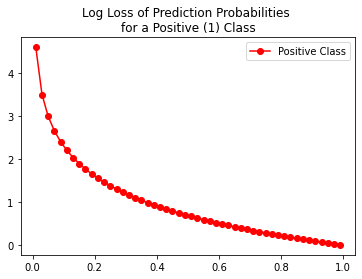

In [37]:
import numpy as np
import matplotlib.pyplot as plt

n = 50
probs = np.linspace(0.01, 0.99, num=n)
y = np.full(n, 1, dtype=int)

def logloss(p, y):
    one = y * np.log(probs)
    two = (1-y)*np.log(1-probs)
    
    return -1*(one+two)

plt.plot(probs, logloss(probs, y), marker='o', color='r', label='Positive Class')
plt.legend()
plt.title('Log Loss of Prediction Probabilities \nfor a Positive (1) Class')
plt.show()

The log-loss metric is provided as a function in Scikit-Learn, which averages the log-loss for every record in the dataset.

Now the question is, what's the baseline log-loss for our dataset? Also, what is the log-loss when I just randomly predict the class, weighted by the share of each class in the distribution?

The baseline log-loss will be the log-loss when I predict a probability of a record belonging to the positive class 48% of the time, since the most prevalent class has a 48% share of the dataset:

In [38]:
n = 100
probs = np.full(n, 0.48, dtype=float)
y = np.concatenate((np.full(48, 1, dtype=float), np.full(52, 0, dtype=float)))

logloss(probs, y).mean()

0.6923469670899614

So I need a log-loss less than 0.69 for the model to be considered better than guessing 0 every time. Now what is the log loss when we just randomly predict the class, weighted by the share of each class in the distribution? That would just be the average of the log-losses for each class:

In [39]:
from sklearn.metrics import log_loss

def calculate_log_loss(class_ratio, multi=10000):
    
    if sum(class_ratio)!=1.0:
        print("warning: Sum of ratios should be 1 for best results")
        class_ratio[-1]+=1-sum(class_ratio)  # add the residual to last class's ratio
    
    actuals=[]
    for i,val in enumerate(class_ratio):
        actuals=actuals+[i for x in range(int(val*multi))]
        

    preds=[]
    for i in range(multi):
        preds+=[class_ratio]

    return (log_loss(actuals, preds))



In [40]:
calculate_log_loss([0.48, 0.38, 0.07, 0.06, 0.01])

1.1209916814687222

So now I have an upper bound on the log-loss to determine if my model is worth it: 0.69. Now I can go ahead and start training the model.

## Training

Alright, so I need to do a little bit of preprocessing. I need to make some cross validation folds so that I can find the best model. After training, I'll write a function to compute some lag features so that I can make predictions into the future.

In [41]:
from sklearn.model_selection import TimeSeriesSplit

In [42]:
tss = TimeSeriesSplit(n_splits=3, test_size=24*90*1, gap=24)

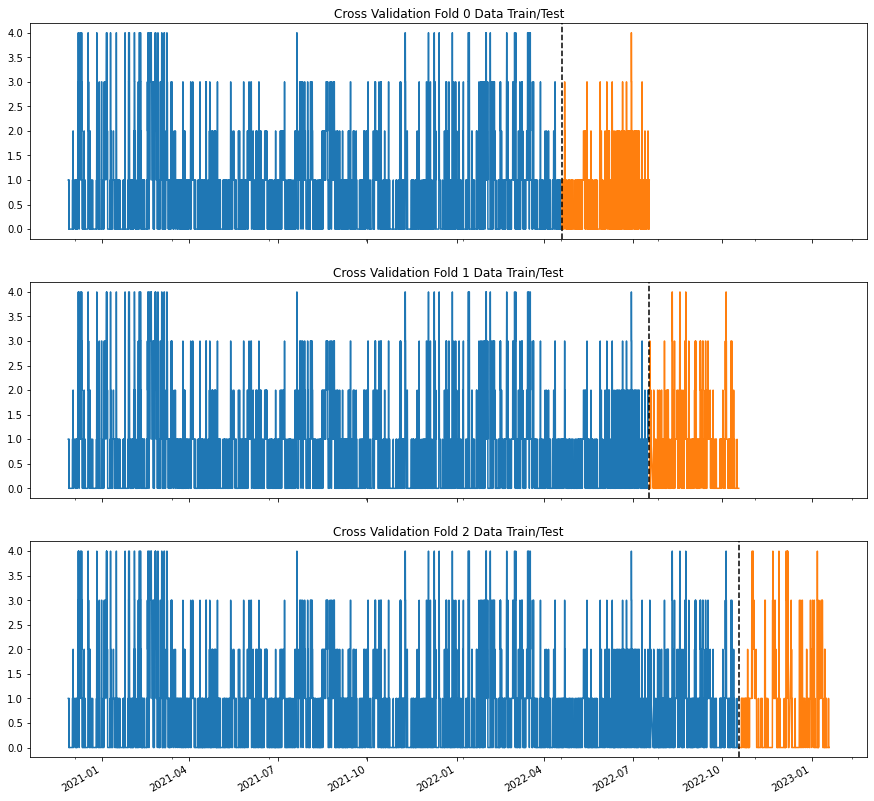

In [43]:
fig, axs = plt.subplots(3, 1, figsize=(15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train_val = df.iloc[train_idx]
    test_val = df.iloc[val_idx]
    train_val['aqi'].plot(ax=axs[fold], 
                          label='Training Set', 
                          title=f'Cross Validation Fold {fold} Data Train/Test')
    test_val['aqi'].plot(ax=axs[fold], 
                          label='Test Set')
    axs[fold].axvline(test_val.index.min(), color='black', ls='--')
    fold += 1    

### Train with Cross Validation

Use cross validation to find some good parameters for the model without overfitting.

In [44]:
df.columns

Index(['aqi', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'co_lag3d', 'no_lag3d', 'no2_lag3d',
       'o3_lag3d', 'so2_lag3d', 'pm2_5_lag3d', 'pm10_lag3d', 'nh3_lag3d',
       'aqi_lag3d', 'aqi_max_lag_3d', 'aqi_mean_lag_3d', 'aqi_std_lag_3d'],
      dtype='object')

In [45]:
import xgboost as xgb

In [46]:
from sklearn.utils.class_weight import compute_sample_weight

In [53]:
fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
               'dayofmonth', 'weekofyear', 'co_lag3d', 'no_lag3d', 'no2_lag3d',
               'o3_lag3d', 'so2_lag3d', 'pm2_5_lag3d', 'pm10_lag3d', 'nh3_lag3d',
               'aqi_lag3d', 'aqi_max_lag_3d', 'aqi_mean_lag_3d', 'aqi_std_lag_3d']
    target = 'aqi'
    
    x_train = train[features]
    y_train = train[target]
    
    x_test = test[features]
    y_test = test[target]
    
    sample_weights = compute_sample_weight(class_weight='balanced', y=train[target])

    clf = xgb.XGBClassifier(n_estimators=1000, 
                            booster='gbtree',
                            early_stopping_rounds=50,
                            max_depth=4,
                            learning_rate=0.01
                           )
    
    clf.fit(x_train, y_train,
            eval_set=[(x_train, y_train), (x_test, y_test)],
            verbose=100,
#             sample_weight=sample_weights  # surprisingly get a little better performance without
           )
    
    y_pred = clf.predict_proba(x_test)
    preds.append(y_pred)
    score = log_loss(y_test, y_pred)
    scores.append(score)

[0]	validation_0-mlogloss:1.60219	validation_1-mlogloss:1.60172
[100]	validation_0-mlogloss:1.20199	validation_1-mlogloss:1.18565
[200]	validation_0-mlogloss:1.05261	validation_1-mlogloss:1.04350
[300]	validation_0-mlogloss:0.97370	validation_1-mlogloss:0.98476
[400]	validation_0-mlogloss:0.92569	validation_1-mlogloss:0.96503
[500]	validation_0-mlogloss:0.89085	validation_1-mlogloss:0.95938
[600]	validation_0-mlogloss:0.86179	validation_1-mlogloss:0.95413
[678]	validation_0-mlogloss:0.84343	validation_1-mlogloss:0.95452
[0]	validation_0-mlogloss:1.60203	validation_1-mlogloss:1.60329
[100]	validation_0-mlogloss:1.19414	validation_1-mlogloss:1.26604
[200]	validation_0-mlogloss:1.04454	validation_1-mlogloss:1.17091
[300]	validation_0-mlogloss:0.96831	validation_1-mlogloss:1.12875
[400]	validation_0-mlogloss:0.92242	validation_1-mlogloss:1.11311
[500]	validation_0-mlogloss:0.88962	validation_1-mlogloss:1.10639
[600]	validation_0-mlogloss:0.86592	validation_1-mlogloss:1.10406
[648]	validati

In [54]:
importances = pd.DataFrame({'feature_importance': clf.feature_importances_}, 
                           index=features).sort_values(by='feature_importance', ascending=False)
print(importances)
print('CV Fold Scores: ', scores)
print(f'Average Score: {np.mean(scores):0.4f}')

                 feature_importance
quarter                    0.088687
o3_lag3d                   0.084822
dayofyear                  0.075440
hour                       0.075347
weekofyear                 0.074102
dayofmonth                 0.056965
no_lag3d                   0.049928
aqi_max_lag_3d             0.049726
dayofweek                  0.047086
aqi_std_lag_3d             0.046639
year                       0.046207
aqi_mean_lag_3d            0.044162
no2_lag3d                  0.043490
month                      0.040180
pm2_5_lag3d                0.038312
pm10_lag3d                 0.035700
nh3_lag3d                  0.035588
so2_lag3d                  0.034931
co_lag3d                   0.031293
aqi_lag3d                  0.001395
CV Fold Scores:  [0.9532737781742104, 1.1040417998615237, 1.1714990730983792]
Average Score: 1.0763


It's kinda of clear from extensive testing that I'm not able to get below that 0.69 threshold. I spent a while learning about feature engineering for time series forecasting and then implemented that knowledge into the data at hand. Not really getting anywhere below 1.0 unfortunately. It's okay though, this is a learning project and I'll do better on future projects!

### Retraining with Full Dataset

In [55]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
           'dayofmonth', 'weekofyear', 'co_lag3d', 'no_lag3d', 'no2_lag3d',
           'o3_lag3d', 'so2_lag3d', 'pm2_5_lag3d', 'pm10_lag3d', 'nh3_lag3d',
           'aqi_lag3d', 'aqi_max_lag_3d', 'aqi_mean_lag_3d', 'aqi_std_lag_3d']
target = 'aqi'

x_all = df[features]
y_all = df[target]

sample_weights = compute_sample_weight(class_weight='balanced', 
                                       y=df[target])

clf = xgb.XGBClassifier(n_estimators=1000, 
                        booster='gbtree',
                        early_stopping_rounds=50,
                        max_depth=4,
                        learning_rate=0.01
                       )

clf.fit(x_all, y_all, eval_set=[(x_all, y_all)], 
        verbose=100, sample_weight=sample_weights)

[0]	validation_0-mlogloss:1.60666
[100]	validation_0-mlogloss:1.43161
[200]	validation_0-mlogloss:1.34171
[300]	validation_0-mlogloss:1.28490
[400]	validation_0-mlogloss:1.24378
[500]	validation_0-mlogloss:1.20784
[600]	validation_0-mlogloss:1.17805
[700]	validation_0-mlogloss:1.15172
[800]	validation_0-mlogloss:1.12683
[900]	validation_0-mlogloss:1.10500
[999]	validation_0-mlogloss:1.08579


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

### Predict Future

In [56]:
preds = clf.predict(future_w_features[features])

In [57]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

### Dump Model

In [59]:
import joblib
import os

# The 'aqi_model' directory will be saved to the model registry
model_dir = 'aqi_model'
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
    
joblib.dump(clf, model_dir + '/xgboost_aqi_model.pkl')

['aqi_model/xgboost_aqi_model.pkl']

Now we need to upload this model to the model registry in Hopsworks.

In [60]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [61]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(future_w_features[features])
output_schema = Schema(future_w_features[target])
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

aqi_model = mr.python.create_model(
    name='xgboost_aqi_model', 
    model_schema=model_schema,
    input_example=future_w_features[features].sample().to_numpy(), 
    description="AQI Predictor")

aqi_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/14486/models/xgboost_aqi_model/1


Model(name: 'xgboost_aqi_model', version: 1)